In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skactiveml.pool import GreedySamplingX
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import tqdm as tqdm
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from scipy import stats


#read in data
df = pd.read_csv('vegetation_data.csv')


Q1 = df['N'].quantile(0.25)
Q3 = df['N'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

df = df[(df['N'] >= lower_bound) & (df['N'] <= upper_bound)]


#create x and y variables
y = df["N"]
y = y.to_numpy()

X = df.drop(["N_level", "N","POINTID"], axis=1)
T = df.drop(["N_level", "N","POINTID"], axis=1)

# Create a StandardScaler object
scaler = StandardScaler()
numeric_features = X.columns[:7]


# Standardize the first 7 features
X[numeric_features] = scaler.fit_transform(X[numeric_features])

X = X.to_numpy()

seed = 3


In [85]:
from tqdm import tqdm
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def split_data(X, y, n_init, seed):
    n = len(y)
    X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=n_init / n, random_state=seed)
    X_pool, X_test, y_pool, y_test = train_test_split(X_pool, y_pool, test_size=0.3, random_state=seed)
    pool_indices = np.arange(len(y_pool))  # Initialize pool indices
    return dict(
        train=dict(X=X_train, y=y_train),
        pool=dict(X=X_pool, y=y_pool, indices=pool_indices),
        test=dict(X=X_test, y=y_test)
    )

def update_data(data, idx):
    data['train']['X'] = np.append(data['train']['X'], np.atleast_2d(data['pool']['X'][idx]), axis=0)
    data['train']['y'] = np.append(data['train']['y'], np.atleast_1d(data['pool']['y'][idx]), axis=0)
    original_idx = data['pool']['indices'][idx]  # Track the original index
    data['pool']['X'] = np.delete(data['pool']['X'], idx, axis=0)
    data['pool']['y'] = np.delete(data['pool']['y'], idx, axis=0)
    data['pool']['indices'] = np.delete(data['pool']['indices'], idx, axis=0)
    return original_idx

def calculate_uncertainty(model, X_pool):
    stage_predictions = np.array([tree.predict(X_pool) for tree in model.estimators_.flatten()])
    uncertainties = np.std(stage_predictions, axis=0)
    return uncertainties

def fit_model(seed, strategy, query_strategy, n_init, n_iterations):
    data = split_data(X, y, n_init, seed)
    scores = np.zeros(n_iterations)
    original_sampled_indices = []
    model = GradientBoostingRegressor(random_state=seed, n_estimators=1000, max_depth=2, max_features=5,min_samples_leaf=5, learning_rate=0.05)

    for i in range(n_iterations):
        model.fit(data['train']['X'], data['train']['y'])
        test_pred = model.predict(data['test']['X'])
        scores[i] = mean_squared_error(test_pred, data['test']['y'], squared=False)

        if len(data['pool']['X']) == 0:
            break  # Exit loop if no more samples to query

        if strategy == 'al':
            if query_strategy == 'greedy':
                min_distances_input = np.min(pairwise_distances(data['pool']['X'], data['train']['X']), axis=1)
                predicted_outputs = model.predict(data['pool']['X'])
                min_distances_output = np.min(pairwise_distances(predicted_outputs.reshape(-1, 1), data['train']['y'].reshape(-1, 1)), axis=1)
                combined_distances = min_distances_input * min_distances_output
                idx = np.argmax(combined_distances)
                sampled_greedy[j,i] = idx
            elif query_strategy == 'variance':
                uncertainties = calculate_uncertainty(model, data['pool']['X'])
                idx = np.argmax(uncertainties)
                sampled_variance[j, i] = idx
        elif strategy == 'random':
            idx = random_sampling(data['pool']['X'])
            sampled_rn[j, i] = idx

        original_idx = update_data(data, idx)
        original_sampled_indices.append(original_idx)


    feature_importances = model.feature_importances_

    return scores, original_sampled_indices, feature_importances

def random_sampling(X_pool):
    idx = np.random.choice(len(X_pool), size=1, replace=False)[0]
    return idx

# Settings
n_init = 100
n_iterations = 150
n_avg = 10

scores_variance = np.zeros((n_avg, n_iterations))
scores_greedy = np.zeros((n_avg, n_iterations))
scores_rn = np.zeros((n_avg, n_iterations))

sampled_variance = np.zeros((n_avg, n_iterations))
sampled_greedy = np.zeros((n_avg, n_iterations))
sampled_rn = np.zeros((n_avg, n_iterations))

original_sampled_indices_variance = []
original_sampled_indices_greedy = []
original_sampled_indices_rn = []

feature_importances_variance = []
feature_importances_greedy = []
feature_importances_random = []

j = 0

for i in tqdm(range(n_avg)):
    seed = 3 + i
    scores_variance[i], original_sampled_indices_var, feature_importances_var = fit_model(seed, "al", "variance", n_init, n_iterations)
    scores_greedy[i], original_sampled_indices_grd, feature_importances_grd = fit_model(seed, "al", "greedy", n_init, n_iterations)
    scores_rn[i], original_sampled_indices_rn, feature_importances_rn = fit_model(seed, "random", None, n_init, n_iterations)

    feature_importances_variance.append(feature_importances_var)
    feature_importances_greedy.append(feature_importances_grd)
    feature_importances_random.append(feature_importances_rn)
    
    original_sampled_indices_variance.extend(original_sampled_indices_var)
    original_sampled_indices_greedy.extend(original_sampled_indices_grd)
    original_sampled_indices_rn.extend(original_sampled_indices_rn)
    print(f'Iteration {i+1}/{n_avg} done')
    j += 1


 10%|█         | 1/10 [02:13<19:59, 133.30s/it]

Iteration 1/10 done


 20%|██        | 2/10 [04:36<18:33, 139.14s/it]

Iteration 2/10 done


 30%|███       | 3/10 [06:51<16:00, 137.28s/it]

Iteration 3/10 done


 40%|████      | 4/10 [09:20<14:11, 141.91s/it]

Iteration 4/10 done


 50%|█████     | 5/10 [12:04<12:28, 149.68s/it]

Iteration 5/10 done


 60%|██████    | 6/10 [14:27<09:50, 147.56s/it]

Iteration 6/10 done


 70%|███████   | 7/10 [16:31<07:00, 140.01s/it]

Iteration 7/10 done


 80%|████████  | 8/10 [18:47<04:37, 138.67s/it]

Iteration 8/10 done


 90%|█████████ | 9/10 [21:43<02:30, 150.19s/it]

Iteration 9/10 done


100%|██████████| 10/10 [24:26<00:00, 146.61s/it]

Iteration 10/10 done


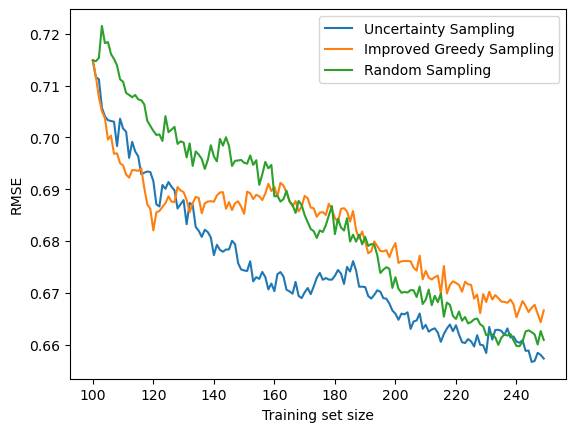

In [86]:
# Plot the results

fig, ax = plt.subplots(1, 1)
line1 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_variance.mean(0),label="Uncertainty Sampling")
line2 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_greedy.mean(0),label="Improved Greedy Sampling")
line3 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_rn.mean(0),label="Random Sampling")
ax.legend(handles=[line1[0], line2[0], line3[0]])
ax.set_xlabel("Training set size")
ax.set_ylabel("RMSE")
plt.show()

In [102]:
gb_X = GradientBoostingRegressor(max_depth=3, max_features=2, n_estimators=1000,random_state=10,min_samples_leaf=5,learning_rate=0.05)

gb_X.fit(X, y)
importances = gb_X.feature_importances_
feature_names = T.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

importance_df['original_feature'] = importance_df['feature'].apply(lambda x: map_to_original_feature(x, categorical_features_mapping))

importance_df = importance_df.groupby('original_feature')['importance'].sum().reset_index()

importances_variance_df = pd.DataFrame(feature_importances_variance, columns=T.columns)
importances_greedy_df = pd.DataFrame(feature_importances_greedy, columns=T.columns)


categorical_features_mapping = {
    'climate': ['climate_BSk', 'climate_Cfa', 'climate_Cfb', 'climate_Dfb', 'climate_Dfc', "climate_Csa", "climate_Csb"],
    'season': ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
}

def map_to_original_feature(feature_name, mapping):
    for original_feature, encoded_features in mapping.items():
        if feature_name in encoded_features:
            return original_feature
    return feature_name

importances_variance_df.columns = [map_to_original_feature(col, categorical_features_mapping) for col in importances_variance_df.columns]
importances_greedy_df.columns = [map_to_original_feature(col, categorical_features_mapping) for col in importances_greedy_df.columns]

# Aggregate importances by original feature
importances_variance_df = importances_variance_df.groupby(by=importances_variance_df.columns, axis=1).sum()
importances_greedy_df = importances_greedy_df.groupby(by=importances_greedy_df.columns, axis=1).sum()



# Calculate mean and standard deviation
mean_importances_variance = importances_variance_df.mean()
std_importances_variance = importances_variance_df.std()

mean_importances_greedy = importances_greedy_df.mean()
std_importances_greedy = importances_greedy_df.std()





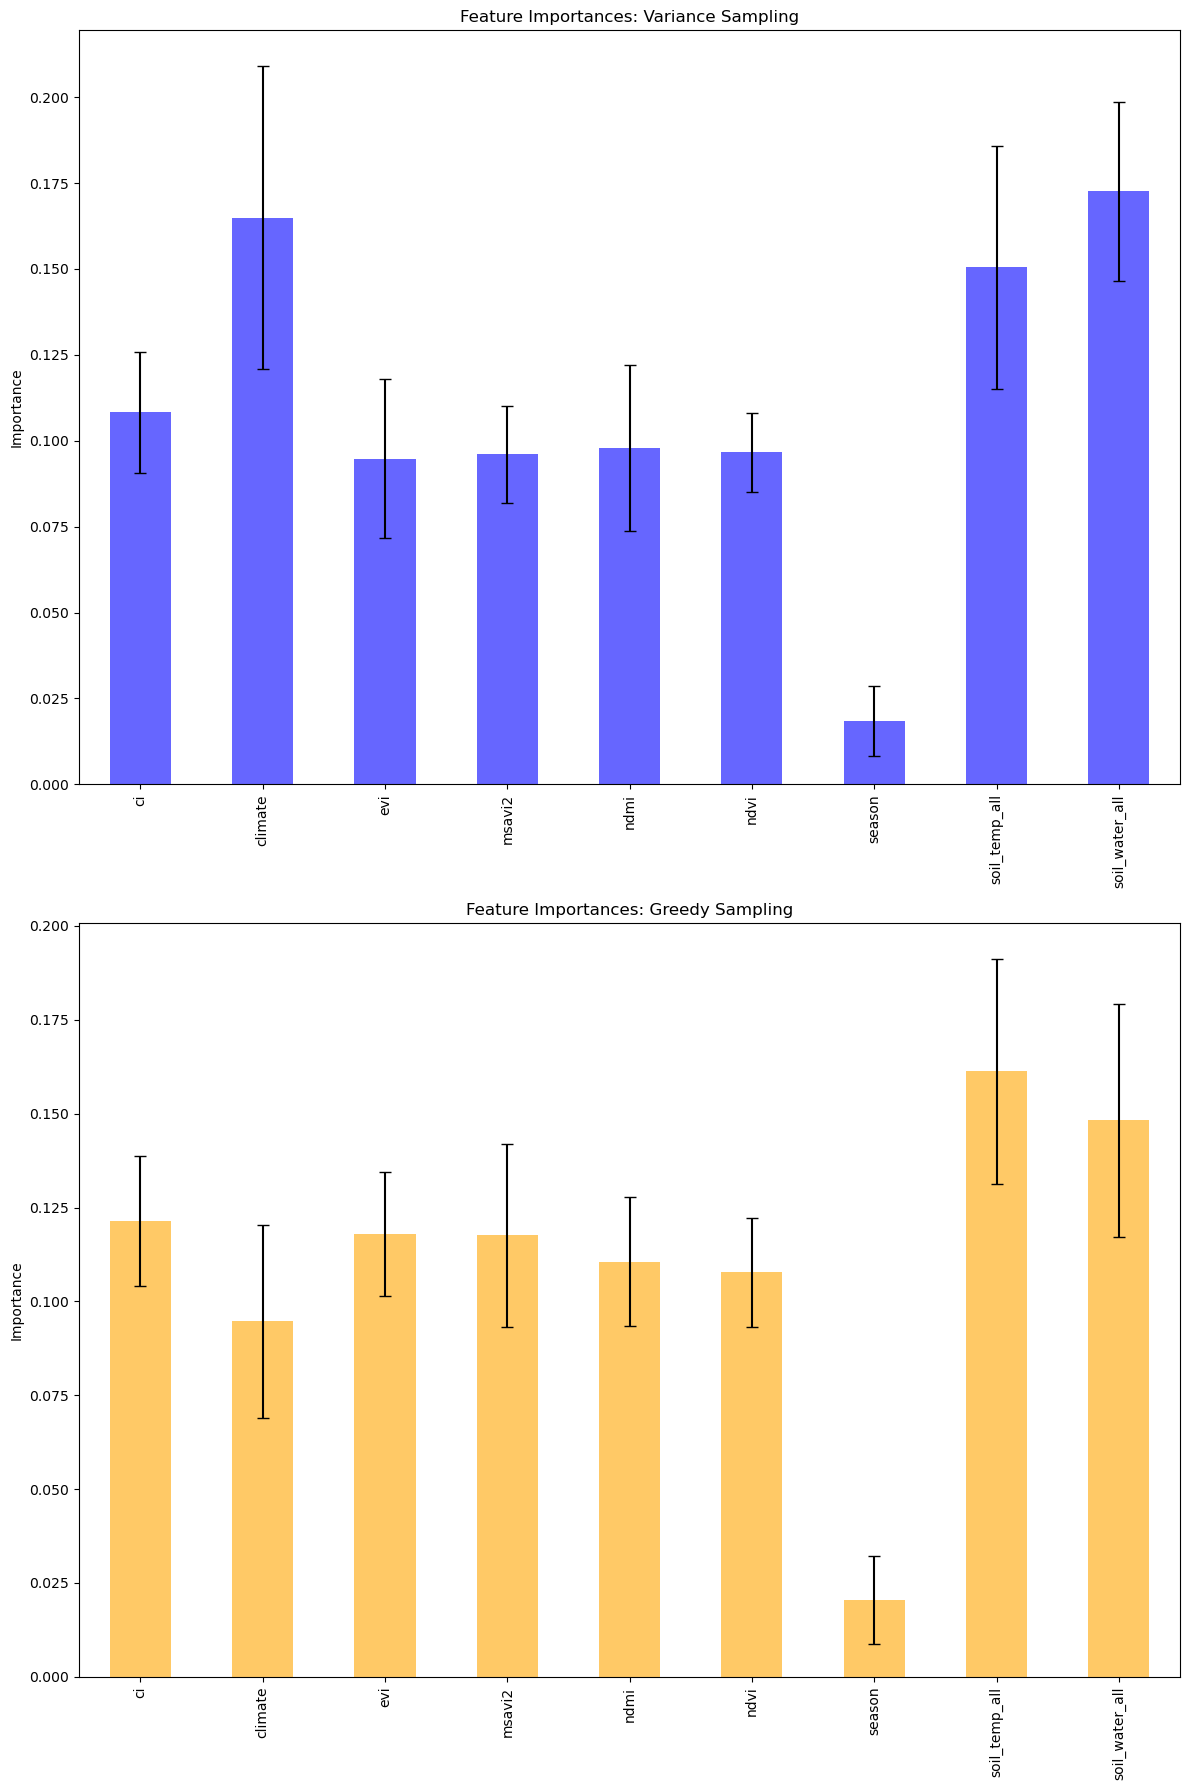

In [94]:
fig, axes = plt.subplots(2, 1, figsize=(12, 18))

mean_importances_variance.plot(kind='bar', yerr=std_importances_variance, capsize=4, ax=axes[0], color='blue', alpha=0.6)

axes[0].set_title('Feature Importances: Variance Sampling')
axes[0].set_ylabel('Importance')

mean_importances_greedy.plot(kind='bar', yerr=std_importances_greedy, capsize=4, ax=axes[1], color='orange', alpha=0.6)
axes[1].set_title('Feature Importances: Greedy Sampling')
axes[1].set_ylabel('Importance')


plt.tight_layout()
plt.show()

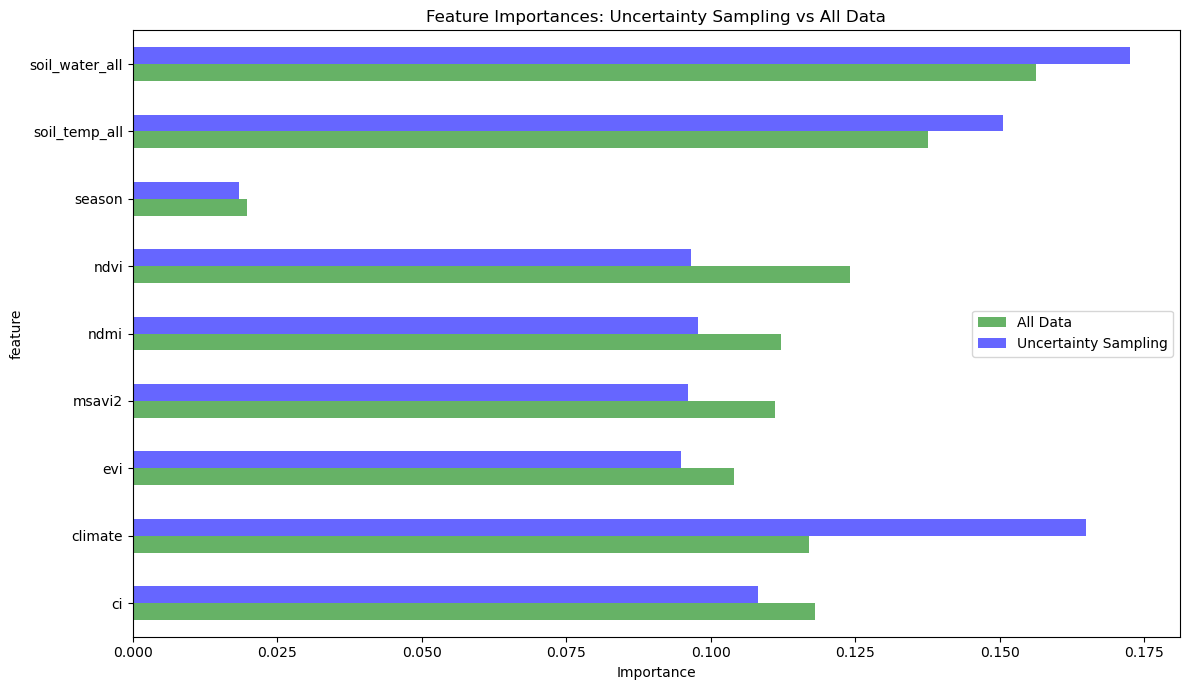

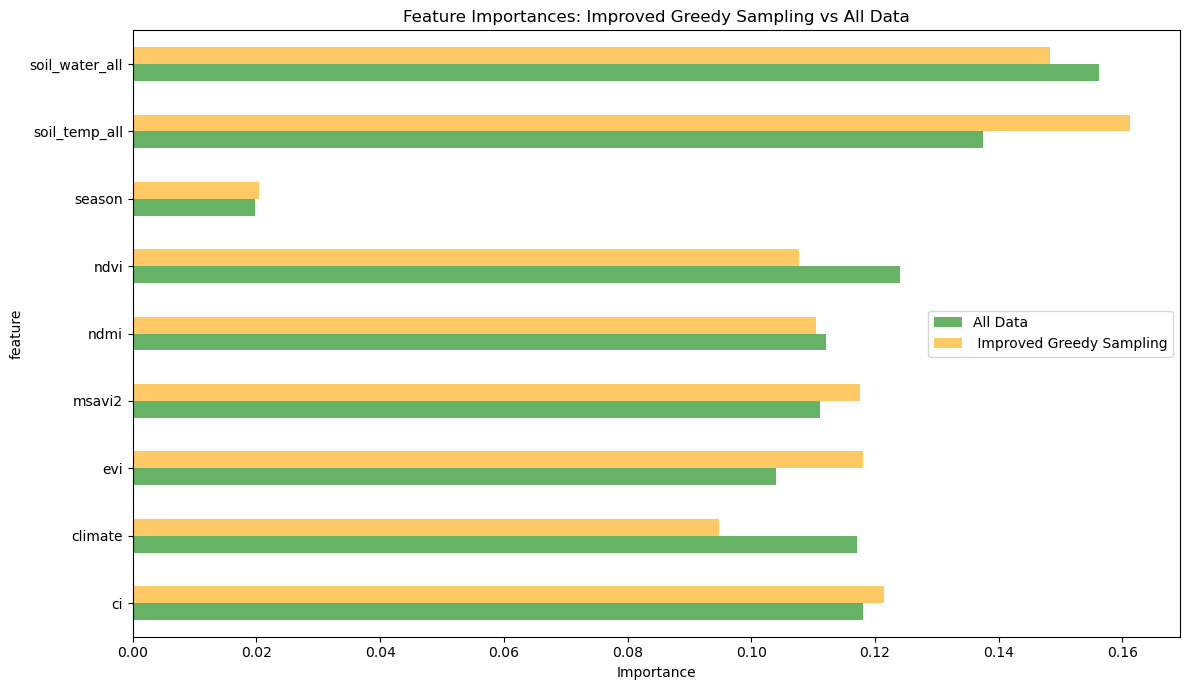

In [114]:
# Combine the DataFrames for plotting
mean_importances_variance_df = pd.DataFrame({
    'feature': mean_importances_variance.index,
    'importance_variance': mean_importances_variance.values,
    'importance_all_data': importance_df.set_index('original_feature').loc[mean_importances_variance.index].importance.values
})

mean_importances_greedy_df = pd.DataFrame({
    'feature': mean_importances_greedy.index,
    'importance_greedy': mean_importances_greedy.values,
    'importance_all_data': importance_df.set_index('original_feature').loc[mean_importances_greedy.index].importance.values
})

# Plotting the combined feature importances for Variance Sampling
fig1, ax1 = plt.subplots(figsize=(12, 7))
mean_importances_variance_df.plot(kind='barh', x='feature', y=['importance_all_data', 'importance_variance'], 
                                  ax=ax1, color=['green', 'blue'], alpha=0.6)
ax1.set_title('Feature Importances: Uncertainty Sampling vs All Data')
ax1.set_xlabel('Importance')
ax1.legend(['All Data', 'Uncertainty Sampling'], loc="center right")
plt.tight_layout()
plt.show()

# Plotting the combined feature importances for Greedy Sampling
fig2, ax2 = plt.subplots(figsize=(12, 7))
mean_importances_greedy_df.plot(kind='barh', x='feature', y=['importance_all_data', 'importance_greedy'], 
                                ax=ax2, color=['green', 'orange'], alpha=0.6)
ax2.set_title('Feature Importances: Improved Greedy Sampling vs All Data')
ax2.set_xlabel('Importance')
ax2.legend(['All Data', ' Improved Greedy Sampling'], loc="center right")
plt.tight_layout()
plt.show()

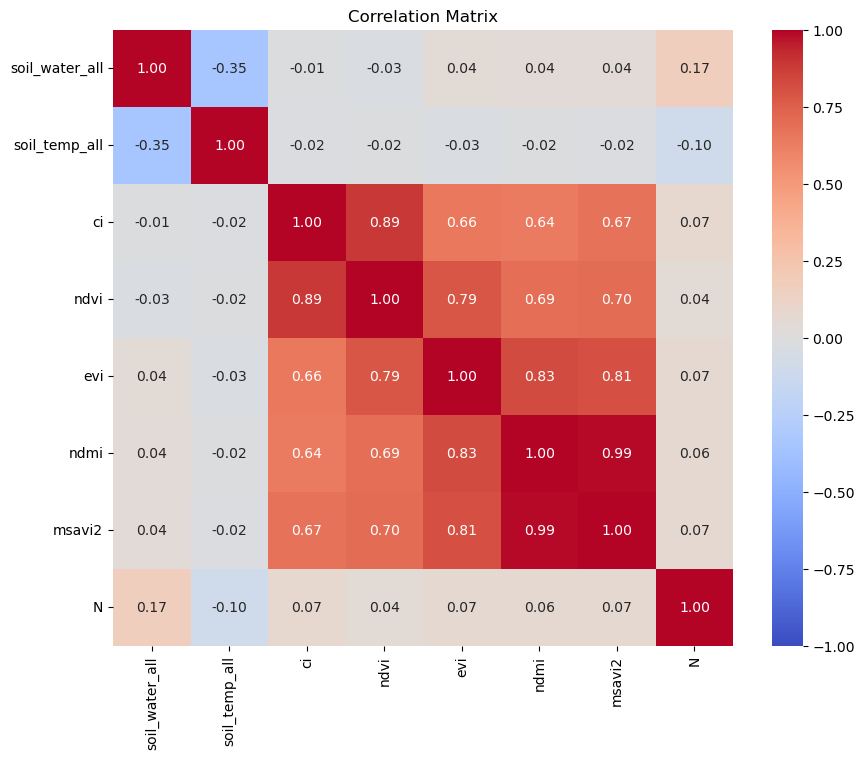

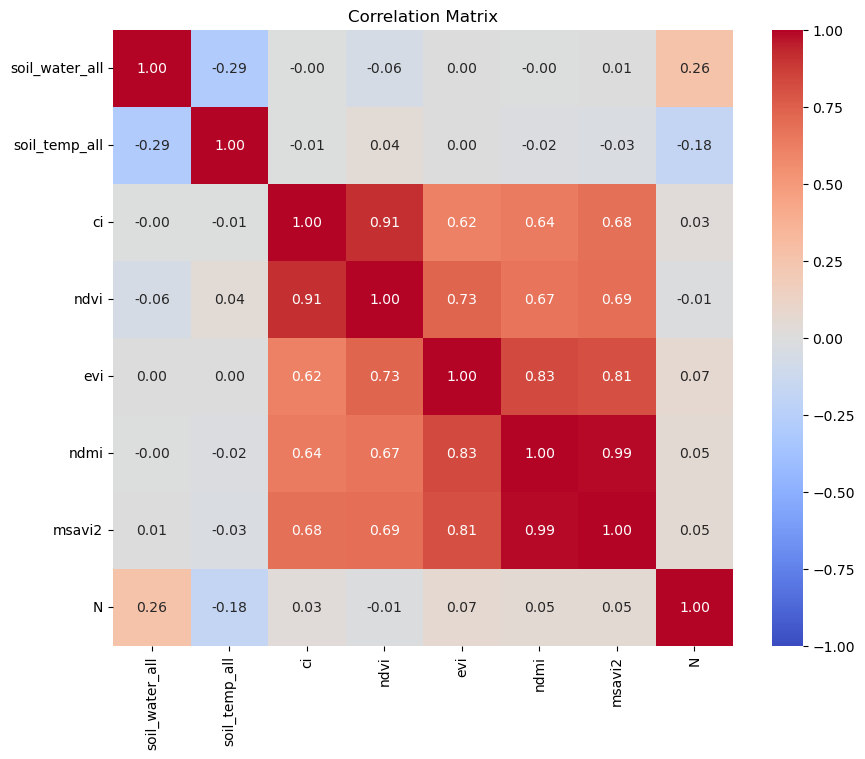

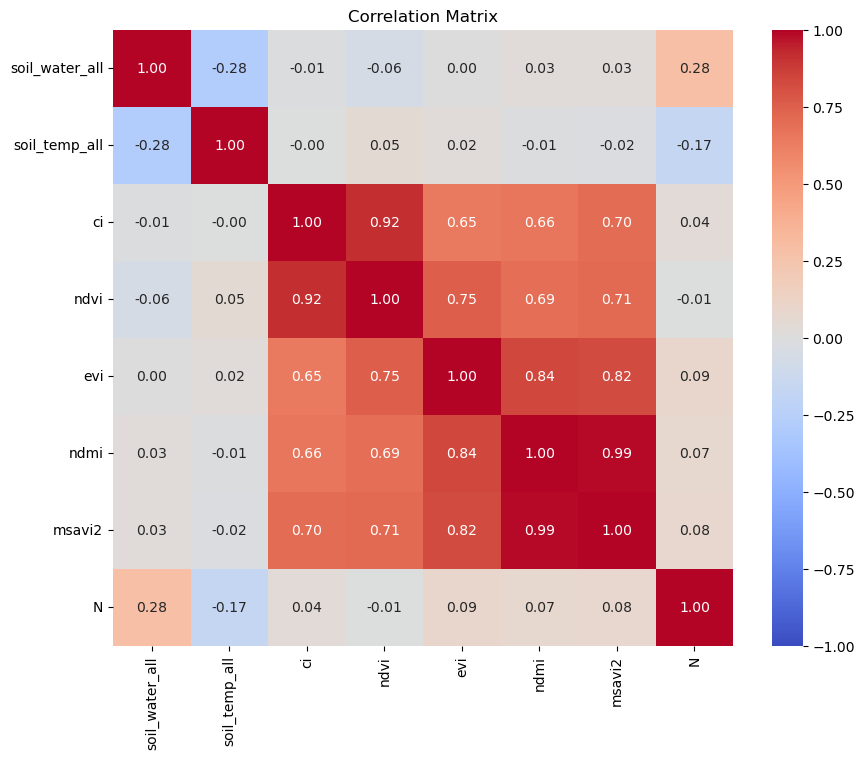

In [123]:
y = df["N"]
y = y.to_numpy()
X = df.drop(["N_level","POINTID","climate_BSk",
    "climate_Cfa",
    "climate_Cfb",
    "climate_Csa",
    "climate_Csb",
    "climate_Dfb",
    "climate_Dfc",
    "season_Fall",
    "season_Spring",
    "season_Summer"], axis=1)

X_greedy = X.iloc[original_sampled_indices_greedy]
X_variance = X.iloc[original_sampled_indices_variance]

correlation_matrix = X.corr(method="spearman")
correlation_matrix_greedy = X_greedy.corr(method="spearman")
correlation_matrix_variance = X_variance.corr(method="spearman")

# Heatmap of the full correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Heatmap of the correlation matrix for Greedy Sampling
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_greedy, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


# Heatmap of the correlation matrix for Variance Sampling
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_variance, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

                Greedy Sampling  Uncertainty Sampling
soil_water_all        98.872706             99.902489
soil_temp_all        100.208473            100.214680
ci                    97.576280            101.279628
ndvi                  93.899007             97.240652
evi                   98.293455            100.850913
ndmi                 164.567768            229.582462
msavi2               121.375331            144.605057
N                     97.493272             97.627281


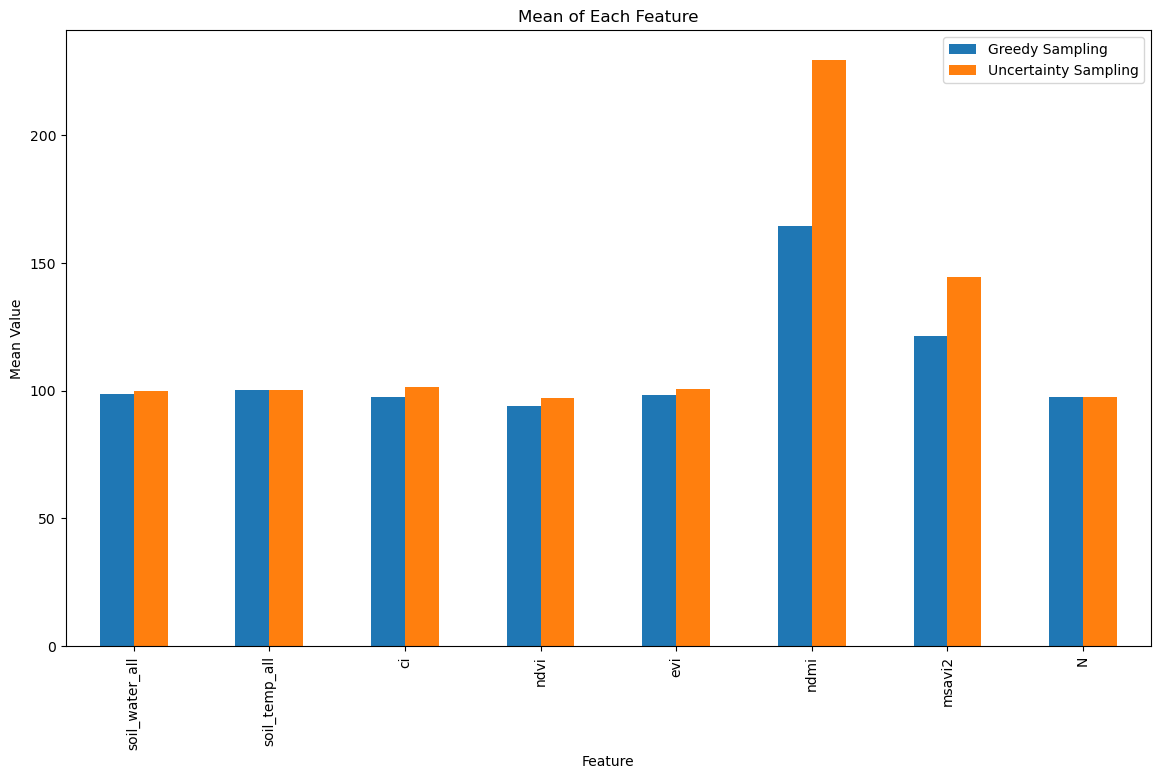

In [127]:
mean_X = X.mean()
mean_X_greedy = X_greedy.mean()
mean_X_variance = X_variance.mean()

# Combine the means into a single DataFrame
means_df = pd.DataFrame({
    'Greedy Sampling': mean_X_greedy / mean_X * 100,
    'Uncertainty Sampling': mean_X_variance / mean_X * 100
})



# Display the combined DataFrame
print(means_df)

# Plotting the means for each feature
means_df.plot(kind='bar', figsize=(14, 8))
plt.title('Mean of Each Feature')
plt.ylabel('Mean Value')
plt.xlabel('Feature')
plt.legend(loc='upper right')
plt.show()

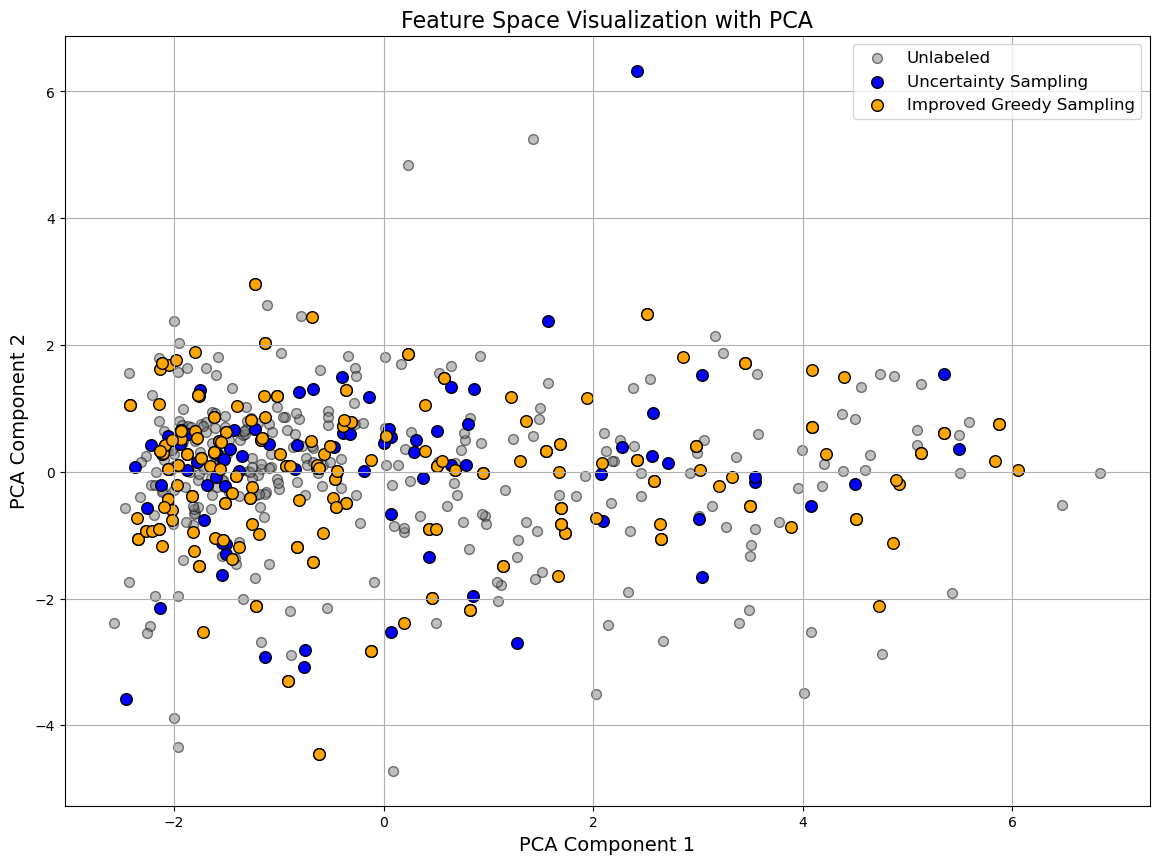

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.model_selection import train_test_split

# Split data
seed = 3
n_init = 100

X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=n_init / 839, random_state=seed)
X_pool, X_test, y_pool, y_test = train_test_split(X_pool, y_pool, test_size=0.3, random_state=seed)

# PCA projection to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pool)



# Visualization
plt.figure(figsize=(14, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='gray', label='Unlabeled', alpha=0.5, s=50, edgecolors='k')
plt.scatter(X_pca[original_sampled_indices_variance, 0], X_pca[original_sampled_indices_variance, 1], c='blue', label='Uncertainty Sampling', s=70, edgecolors='k')
plt.scatter(X_pca[original_sampled_indices_greedy, 0], X_pca[original_sampled_indices_greedy, 1], c='orange', label='Improved Greedy Sampling', s=70, edgecolors='k')

plt.legend(fontsize=12)
plt.title('Feature Space Visualization with PCA', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.grid(True)
plt.show()
